<a href="https://colab.research.google.com/github/sushi15/Sensor-fusion/blob/main/Constant_Velocity_Kalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

# Required matrix definitions (state vectors)

Initial State : x0 (x-coordinate, y-coordinate, speed in x, speed in y) 

For k > 1 : xk = A . x(k - 1)

In [ ]:
x = np.matrix([[5.7, 6.1, 2.5, 3.4]]).T
print(x, x.shape)
#plt.scatter(float(x[0]),float(x[1]), s=100)
#plt.title('Initial Location')

[[5.7]
 [6.1]
 [2.5]
 [3.4]] (4, 1)


Initial Uncertainty : P0 (diagonal values = standard deviation squared in same order as in x0)

In [ ]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)


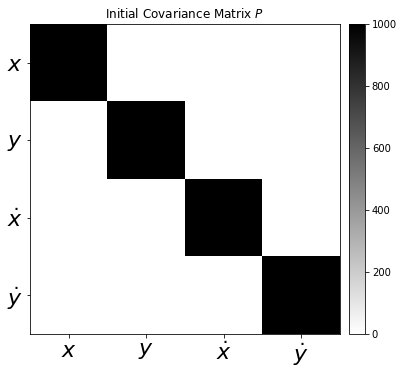

In [ ]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

A (dynamic matrix)

In [ ]:
dt = 0.1 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]] (4, 4)


H (measurement matrix) : only for measuring speeds in both axes

In [ ]:
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]] (2, 4)


R (measurement noise covariance) : standard deviation squared for speeds in both axes

In [ ]:
ra = 10.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)

[[100.   0.]
 [  0. 100.]] (2, 2)


Q (process noise covariance)

In the constant velocity model, acceleration must be 0, but factors like wind may influence the movement of the rover and cause acceleration disturbance (noise). Cross correlation is not assumed to be true (force acting along y axis will not influence acceleration in x axis and vice versa). 

In [ ]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('\Delta t')

As = Matrix([[1, 0, dts, 0],
             [0, 1, 0, dts],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])
# this
Gs = Matrix([dts**2/2, dts]) 
Gs

⎡        2⎤
⎢\Delta t ⎥
⎢─────────⎥
⎢    2    ⎥
⎢         ⎥
⎣\Delta t ⎦

In [ ]:
Gs*Gs.T

⎡        4          3⎤
⎢\Delta t   \Delta t ⎥
⎢─────────  ─────────⎥
⎢    4          2    ⎥
⎢                    ⎥
⎢        3           ⎥
⎢\Delta t           2⎥
⎢─────────  \Delta t ⎥
⎣    2               ⎦

In [ ]:
sv = 8.8

Q = np.matrix([[(dt**4)/4, 0, (dt**3)/2, 0],
               [0, (dt**4)/4, 0, (dt**3)/2],
               [(dt**3)/2, 0, dt**2, 0],
               [0, (dt**3)/2, 0, dt**2]]) * sv**2

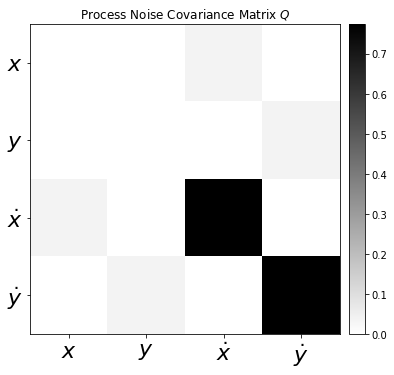

In [ ]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

I

In [ ]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


## Measurements

In [ ]:
# Using randomly generated values 
# For the rover we will need to use the IMU/encoder readings in matrix measurements 
# We will also need the last known position from GPS right before it stopped 
# transmitting data, along with the IMU readings then 

m = 200 # Measurements
vx= 20 # in X
vy= 10 # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))

measurements = np.vstack((mx,my))

print(measurements.shape)

print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % R[0,0])

(2, 200)
Standard Deviation of Acceleration Measurements=1.06
You assumed 100.00 in R.


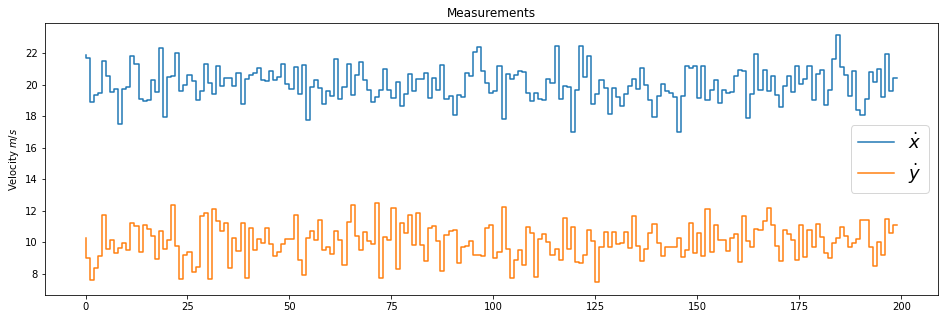

In [ ]:
fig = plt.figure(figsize=(16,5))

plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})

In [ ]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))

# Filter

x(k + 1) = A . xk 

P(k + 1) = A . Pk . A' + Q 

Kk = Pk . H' (H . Pk . H' + R)^(-1) i.e. Kalman gains

xk = xk + Kk(zk - H . xk) 

Pk = Pk (I - Kk . H)

In [ ]:
for n in range(len(measurements[0])):
 
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    
    
    # Save states (for Plotting)
    savestates(x, Z, P, R, K)

# Performance Analysis

Kalman Gains

In [ ]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the better the measurement fulfills the prediction)')
    plt.legend(loc='best',prop={'size':22})

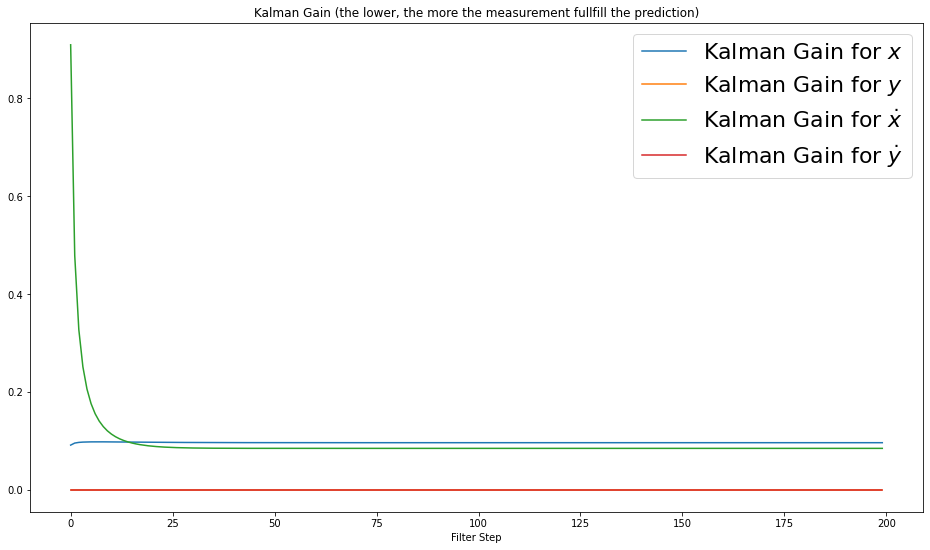

In [ ]:
plot_K()

Uncertainty Matrix

In [ ]:
def plot_P():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Px, label='$x$')
    plt.plot(range(len(measurements[0])),Py, label='$y$')
    plt.plot(range(len(measurements[0])),Pdx, label='$\dot x$')
    plt.plot(range(len(measurements[0])),Pdy, label='$\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

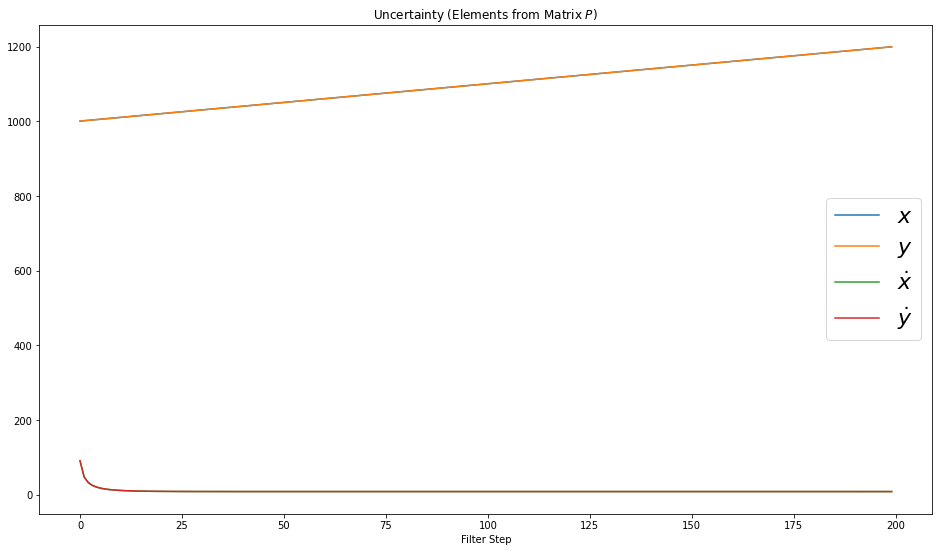

In [ ]:
plot_P()

State estimate (x)

In [ ]:
def plot_x():
    fig = plt.figure(figsize=(16,9))
    plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
    plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

    plt.axhline(vx, color='#999999', label='$\dot x_{real}$')
    plt.axhline(vy, color='#999999', label='$\dot y_{real}$')

    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylim([0, 30])
    plt.ylabel('Velocity')

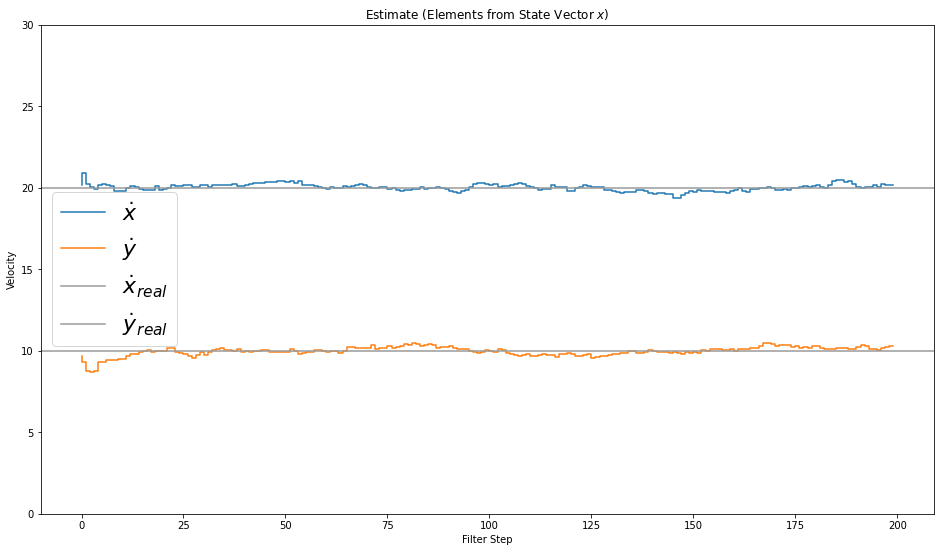

In [ ]:
plot_x()

Position

In [ ]:
def plot_xy():
    fig = plt.figure(figsize=(16,16))
    plt.scatter(xt,yt, s=20, label='State', c='k')
    plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')

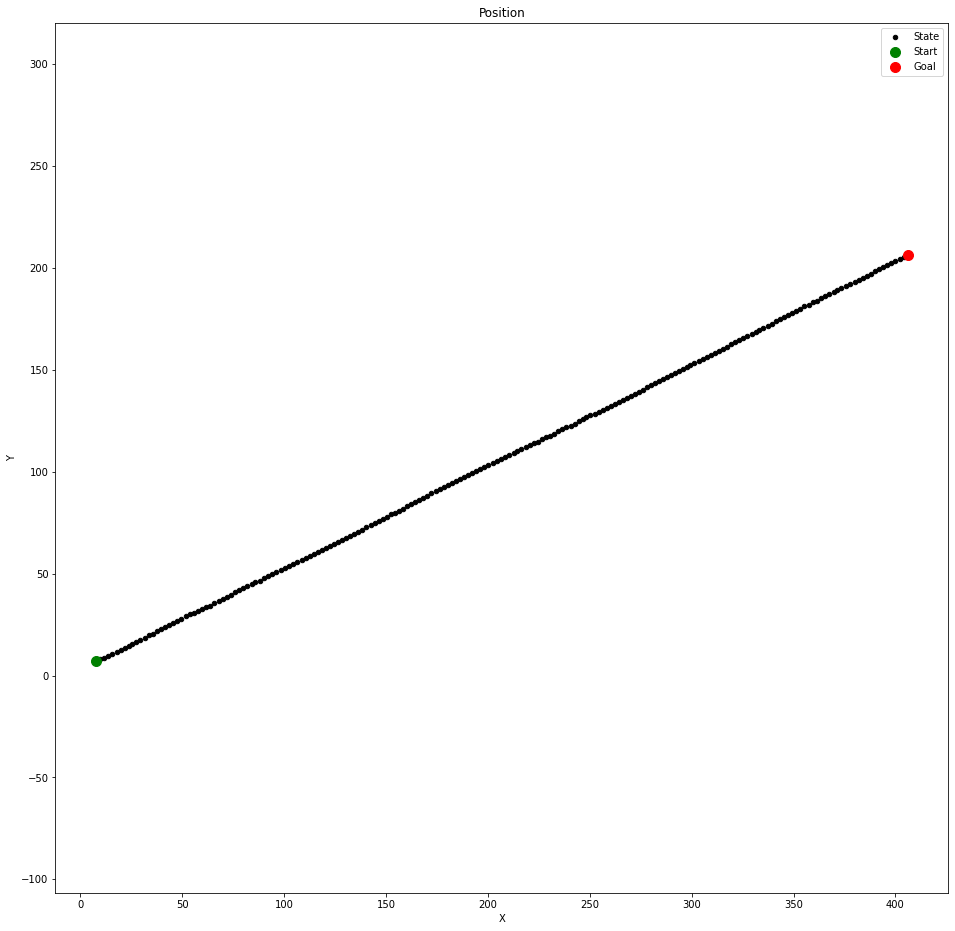

In [ ]:
plot_xy()